<a href="https://colab.research.google.com/github/RaquelHernanz/Projects_II_HeartDataset/blob/master/Dataset_Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and import

In [1]:
import pandas as pd
import numpy as np
import random
import copy
import os
import math

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Sklearn
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

In [2]:
heart_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/heart.csv")

# 1. About missing rows and duplicates

As it was mentioned before, there are no missing rows in the dataset and the idea of removing the duplicates is discarded because the patients cannot be identified from on to another. So in this aspect no modifications are required.

# 2. Outlier values and unbalanced ratio

On the one hand, some of the features present outliers that have made the histograms to become skewn or shifted towards one side, instead of presenting a normal distribution. For instance, a cholesterol level of 526 or 564 mmHg are not normal even for a human being. On the other hand, the sex attribute is unbalanced, only having 30% of females can be detrimental for future uses of the dataset for modelling predictions.

**Proposed solutions:**
- For the oulier values there are several strategies:
  1. Compress the tail by feature transformation (log transformation, normalization).
  2. Remove the patients with the abnormal values.
  3. Modify the value column were the outliers are present.
- For the unbalanced sex attribute:
  1. Separate the male and female cohorts.
  2. Sampling with replacement only with the female cohort.
  3. Create synthetic instances.

However, given the complexity of solving the issue of the sex and the scale of the project, the focus will be on solving the outlier issue.

## Outlier Detection (KNN distance + density-based)

**Purpose:**
This pipeline applies unsupervised distance- and density-based methods to identify atypical observations in key continuous cardiovascular variables that are prone to extreme values and measurement noise.

- *Targeted feature selection:*
Variables `chol`, `thalach`, `trestbps`, `oldpeak` are chosen due to their known clinical variability and potential to generate extreme or implausible values.

- *Robust preprocessing:*
Robust scaling is used to limit the influence of extreme values while preserving the structure of typical patient data.

- *Complementary detection strategies:*
KNN mean distance captures globally isolated observations, while a density-based criterion identifies samples in locally sparse regions using a data-driven radius.

- *Combined decision rule:*
The union of both methods increases robustness by detecting different types of anomalous patterns without relying on a single assumption.

### **Combined result:** 104 flagged observations

In [3]:
# Parameters
# ==========================
features = ["chol", "thalach", "trestbps", "oldpeak"]

k = 5                    # neighbors for KNN & p
knn_percentile = 97      # percentile threshold for KNN outliers
radius_percentile = 90   # percentile to set R from the k-th neighbor distance


# 1) Data selection & cleaning
# ==========================
X_raw = heart_dataset[features].copy()

# Option A: drop rows with NaN
X = X_raw.dropna().copy()
kept_index = X.index  # link back to original df indices

# (Alternative: impute)
# X = X_raw.fillna(X_raw.median())
# kept_index = X.index

print(f"Original rows: {len(heart_dataset)} | Used after cleaning: {len(X)}")

# 2) Robust scaling
# ==========================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 3) KNN mean distance method
# ==========================
nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean")  # +1 includes self
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)
knn_mean_dist = distances[:, 1:].mean(axis=1)  # ignore self distance

knn_thresh = np.percentile(knn_mean_dist, knn_percentile)
knn_outliers_mask = knn_mean_dist >= knn_thresh

# 4) Density-based method (data-driven R)
# ==========================
kth_dist = distances[:, -1]
R = np.percentile(kth_dist, radius_percentile)
p = k

nn_radius = NearestNeighbors(radius=R, metric="euclidean")
nn_radius.fit(X_scaled)
radius_neighbors = nn_radius.radius_neighbors(X_scaled, return_distance=False)

density_counts = np.array([len(ids) - 1 for ids in radius_neighbors])  # exclude self
density_outliers_mask = density_counts < p

# 5) Combine results & summary table
# ==========================
combined_mask = knn_outliers_mask | density_outliers_mask
used_idx = kept_index.to_numpy()

summary = pd.DataFrame({
    "index_df": used_idx,
    **{col: X[col].values for col in features},
    "KNN_mean_dist": knn_mean_dist,
    "KNN_outlier": knn_outliers_mask,
    "Density_neighbors": density_counts,
    "Density_outlier": density_outliers_mask,
    "Outlier_any": combined_mask
})

outliers_any = summary[summary["Outlier_any"]].sort_values(
    by=["KNN_outlier","Density_outlier","KNN_mean_dist"],
    ascending=[False, False, False]
).reset_index(drop=True)

print("=== Outlier detection summary ===")
print(f"Total analyzed rows: {len(X)}")
print(f"KNN (k={k}) outliers: {knn_outliers_mask.sum()}  (threshold p{knn_percentile}={knn_thresh:.4f})")
print(f"Density (R={R:.4f}, p={p}) outliers: {density_outliers_mask.sum()}")
print(f"Union (any method): {combined_mask.sum()}")
outliers_any.head(10)


Original rows: 1025 | Used after cleaning: 1025
=== Outlier detection summary ===
Total analyzed rows: 1025
KNN (k=5) outliers: 32  (threshold p97=0.5588)
Density (R=0.6964, p=5) outliers: 104
Union (any method): 104


,index_df,chol,thalach,trestbps,oldpeak,KNN_mean_dist,KNN_outlier,Density_neighbors,Density_outlier,Outlier_any
0,158,564,160,115,1.6,1.574044,True,2,True,True
1,192,564,160,115,1.6,1.574044,True,2,True,True
2,464,564,160,115,1.6,1.574044,True,2,True,True
3,69,164,145,160,6.2,0.971897,True,2,True,True
4,393,164,145,160,6.2,0.971897,True,2,True,True
5,526,164,145,160,6.2,0.971897,True,2,True,True
6,151,283,195,192,0.0,0.898963,True,2,True,True
7,246,283,195,192,0.0,0.898963,True,2,True,True
8,326,283,195,192,0.0,0.898963,True,2,True,True
9,356,176,90,164,1.0,0.752863,True,2,True,True


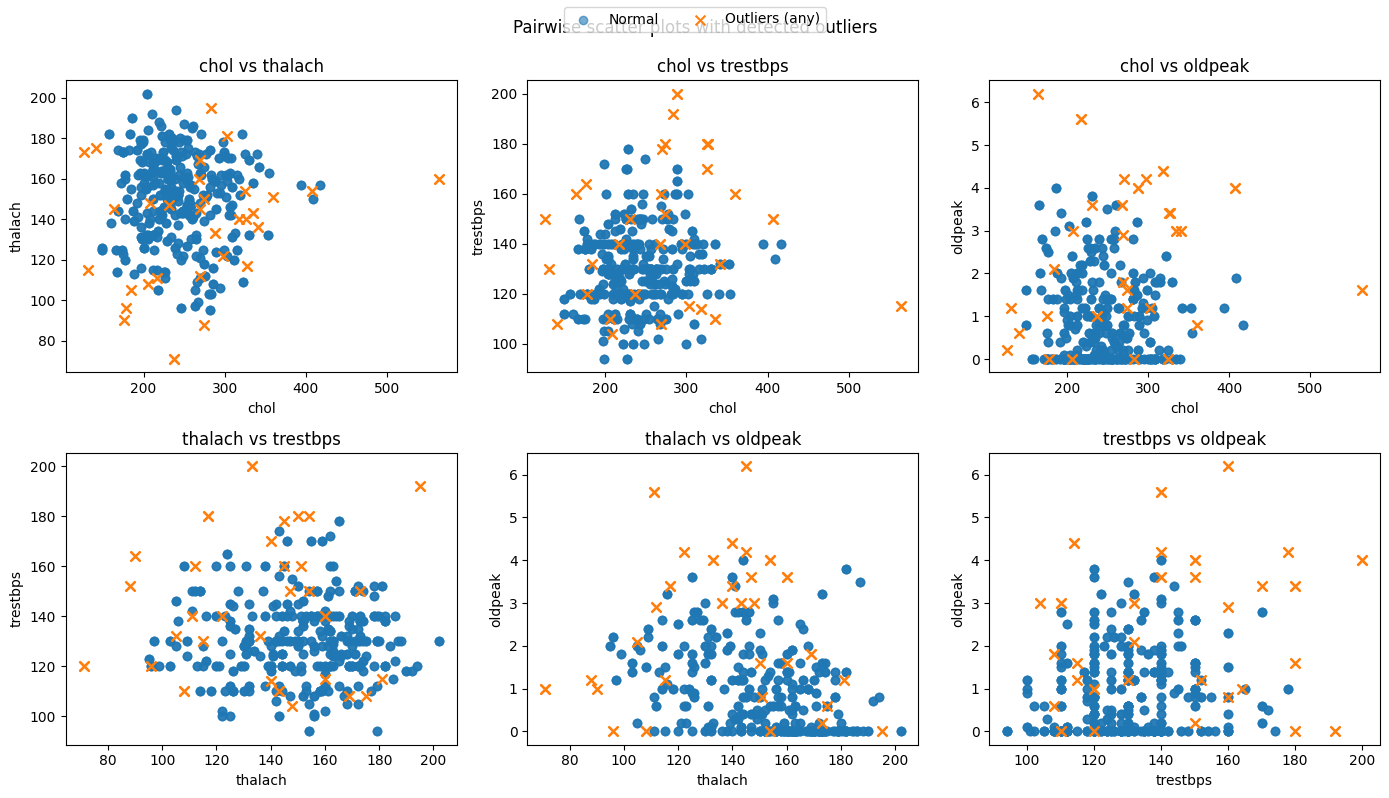

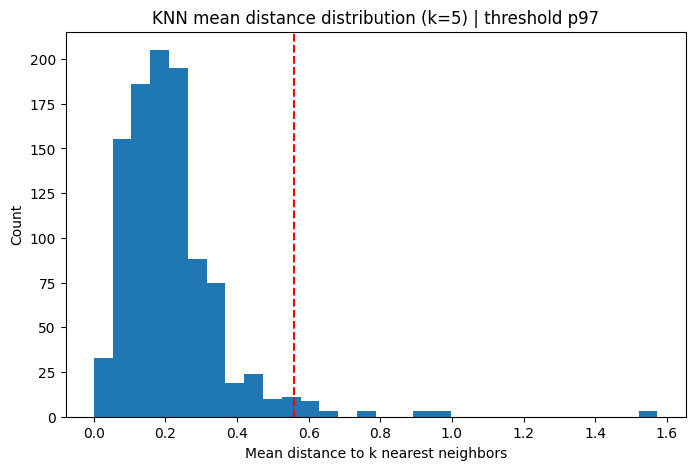

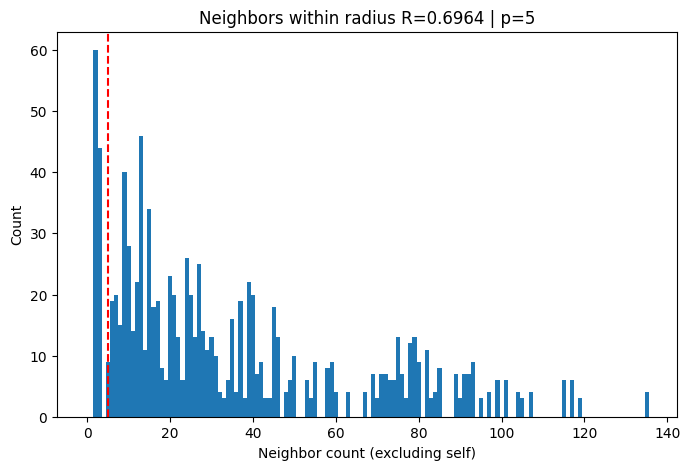

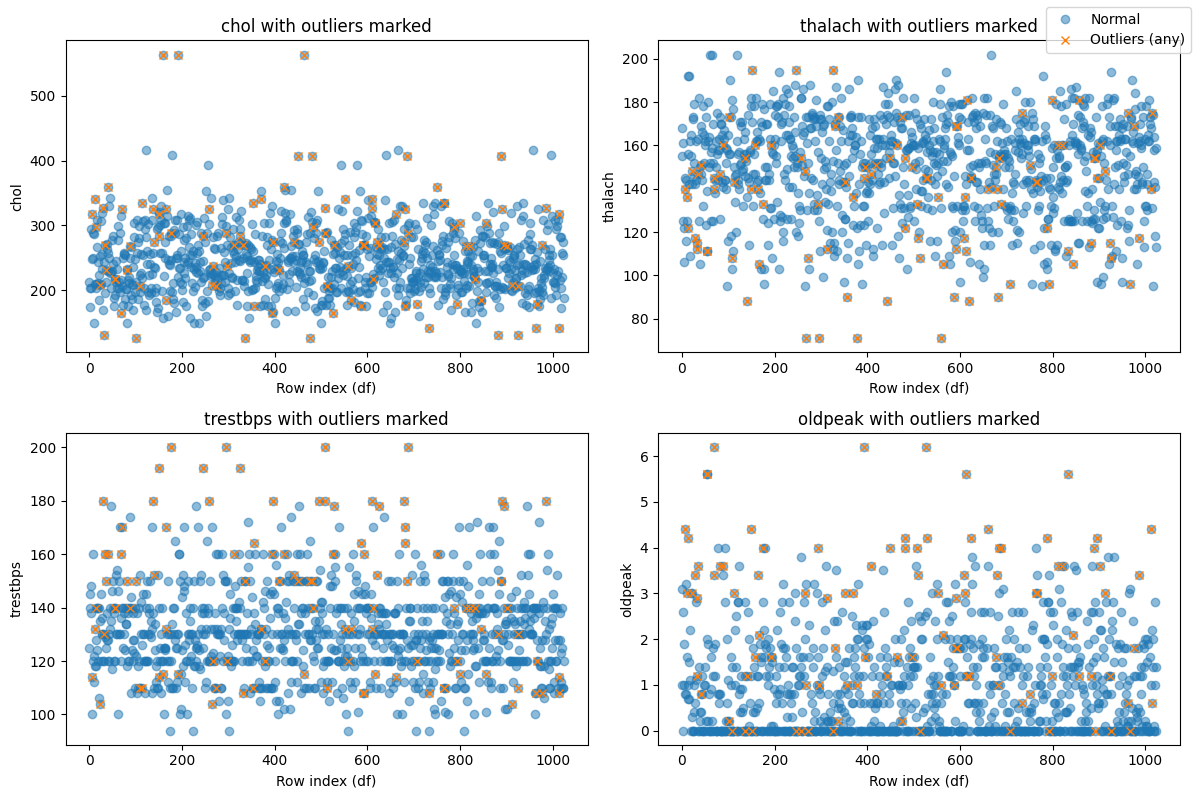

In [4]:
# A) Pairwise scatter plots with outliers highlighted
pairs = [("chol", "thalach"), ("chol", "trestbps"), ("chol", "oldpeak"),
         ("thalach", "trestbps"), ("thalach", "oldpeak"), ("trestbps", "oldpeak")]


df = heart_dataset.copy()
mask_df = pd.Series(False, index=df.index)
mask_df.loc[used_idx] = combined_mask

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()
for ax, (xcol, ycol) in zip(axes, pairs):
    ax.scatter(df.loc[~mask_df, xcol], df.loc[~mask_df, ycol], alpha=0.6, label="Normal")
    ax.scatter(df.loc[mask_df, xcol], df.loc[mask_df, ycol],
               marker="x", s=50, label="Outliers (any)")
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.set_title(f"{xcol} vs {ycol}")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Pairwise scatter plots with detected outliers")
plt.show()

# B) KNN distance distribution
plt.figure(figsize=(8,5))
plt.hist(knn_mean_dist, bins=30)
plt.axvline(knn_thresh, linestyle="--", color="red")
plt.title(f"KNN mean distance distribution (k={k}) | threshold p{knn_percentile}")
plt.xlabel("Mean distance to k nearest neighbors")
plt.ylabel("Count")
plt.show()

# C) Density neighbors count
plt.figure(figsize=(8,5))
bins = np.arange(0, density_counts.max()+2) - 0.5
plt.hist(density_counts, bins=bins)
plt.axvline(p, linestyle="--", color="red")
plt.title(f"Neighbors within radius R={R:.4f} | p={p}")
plt.xlabel("Neighbor count (excluding self)")
plt.ylabel("Count")
plt.show()

# D) Feature-wise index plots highlighting outliers
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for ax, col in zip(axes, features):
    ax.plot(df.index, df[col], linestyle="", marker="o", alpha=0.5, label="Normal")
    ax.plot(df.index[mask_df], df.loc[mask_df, col],
            linestyle="", marker="x", markersize=6, label="Outliers (any)")
    ax.set_xlabel("Row index (df)")
    ax.set_ylabel(col)
    ax.set_title(f"{col} with outliers marked")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()



## Removal of the rows

**Purpose:**
This preprocessing block detects and removes outliers using complementary multivariate and univariate rules, and validates the effect visually with before/after distributions.

- *Targeted variables & sensitivity controls:*
The analysis focuses on high-variance continuous features (chol, thalach, trestbps, oldpeak). Parameters (k, percentiles, IQR whisker) act as explicit “sensitivity knobs” to control how strict the filtering is.

- *Robust scaling for fair distances:*
RobustScaler (median/IQR-based) reduces the impact of extremes so KNN distances reflect overall atypicality rather than raw unit magnitude.

- *Multivariate detection (two perspectives):*
KNN mean distance flags globally isolated samples, while the radius-based density rule (R derived from the k-th neighbor distance) identifies locally sparse observations.

- *Univariate safety net (IQR rule):*
The IQR whisker criterion catches single-variable extreme values that may be clinically implausible even if they do not appear multivariately isolated.

- *Union + index mapping + removal:*
Outliers are defined by the union of methods, mapped back to the original dataframe indices, and removed consistently. Histograms before/after confirm whether removal reduces extreme tails without distorting the core distribution.

Original rows: 1025 | Used after dropna: 1025
=== Outlier removal summary ===
KNN outliers:        32 (threshold p97 = 0.5588)
Density outliers:    104 (R=0.6964, p=5)
IQR outliers:        57 (whisker=1.5)
Union (any method):  123
Rows to drop (unique across methods): 123

Histograms BEFORE outlier removal


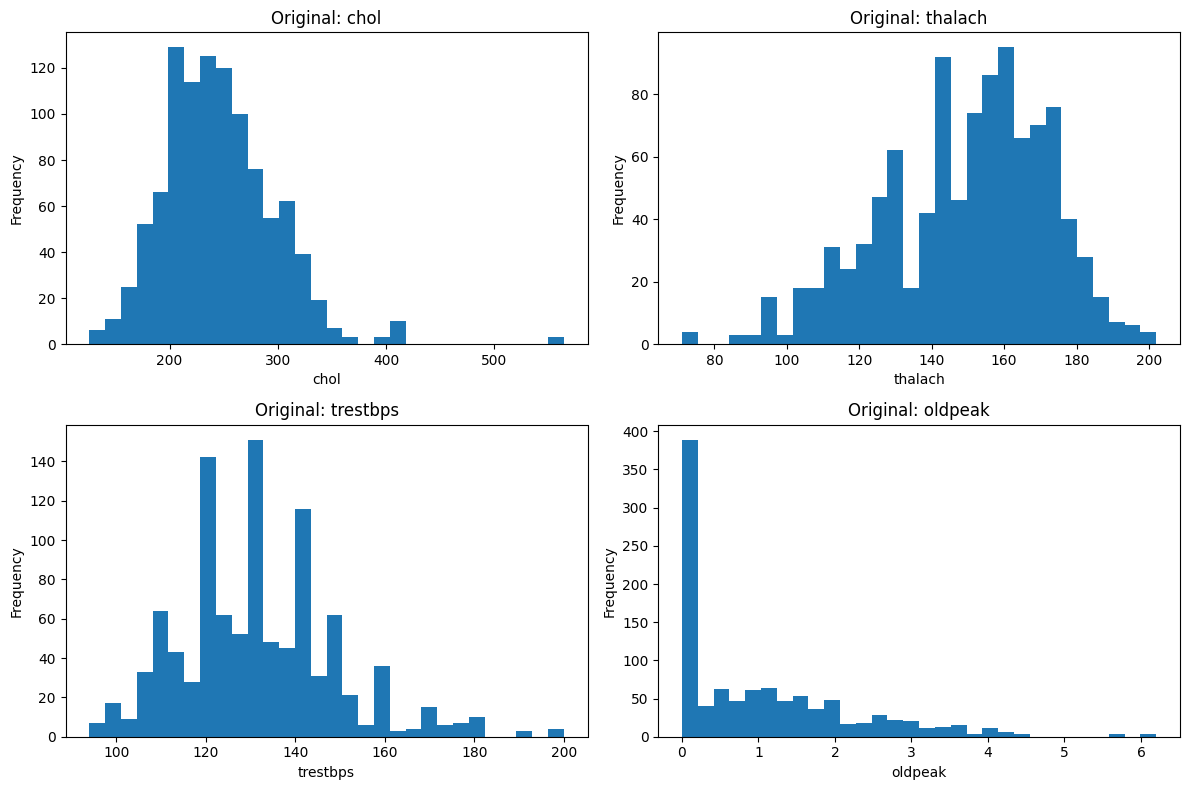

Cleaned dataset size: 902

Histograms AFTER outlier removal


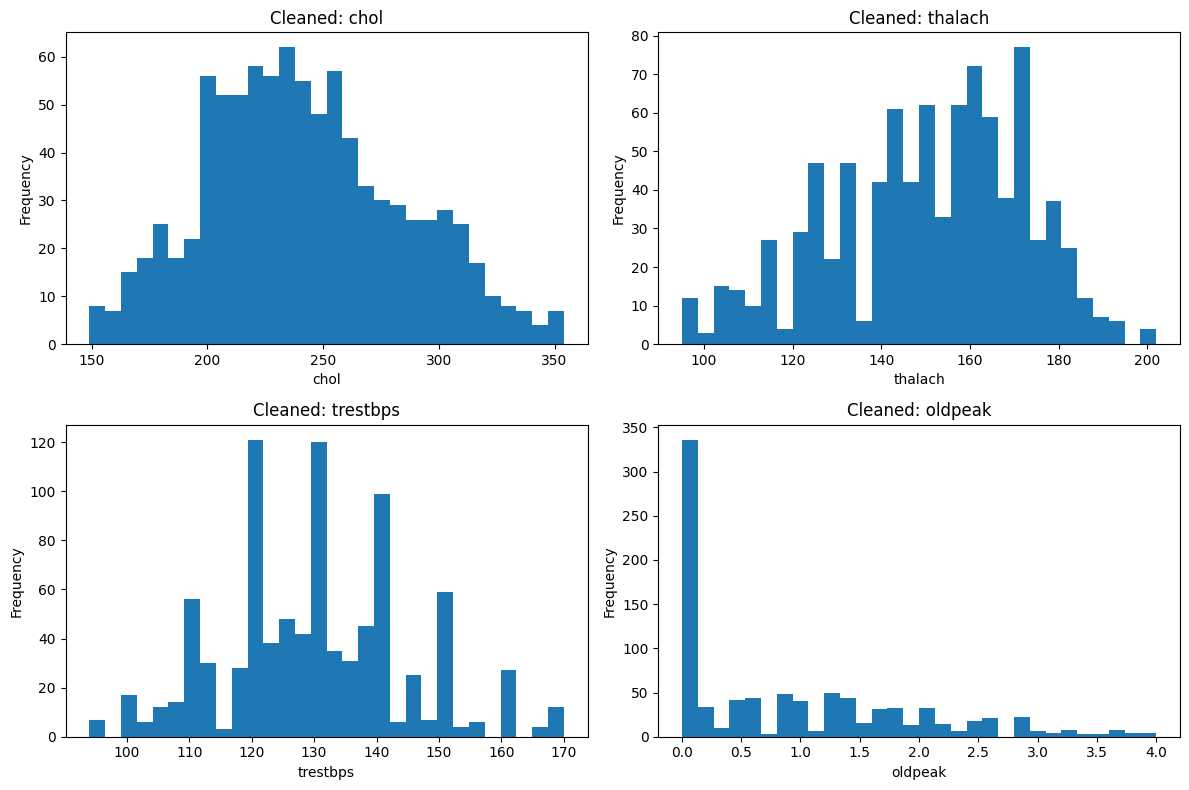

In [5]:
# Config
# ==========================
features = ["chol", "thalach", "trestbps", "oldpeak"]

# Sensitivity knobs
k = 5                       # neighbors for KNN & p
knn_percentile = 97         # KNN outlier threshold (raise => stricter, fewer outliers)
radius_percentile = 90      # to derive R from the k-th neighbor distance (raise => larger R => fewer outliers)
iqr_whisker = 1.5           # IQR whisker for the univariate rule (2.0 = stricter, 1.0 = looser)


# Helpers
# ==========================
def plot_histograms(df_plot, cols, title_prefix=""):
    n = len(cols)
    rows = 2
    cols_grid = 2
    fig, axes = plt.subplots(rows, cols_grid, figsize=(12, 8))
    axes = axes.ravel()
    for ax, col in zip(axes, cols):
        ax.hist(df_plot[col].dropna().values, bins=30)
        ax.set_title(f"{title_prefix}{col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
    # If fewer than 4 variables, hide empty axes
    for j in range(len(cols), len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()

def univariate_iqr_mask(X, whisker=1.5):
    """Return boolean mask (True = outlier in any column) using IQR rule per column."""
    mask_any = np.zeros(len(X), dtype=bool)
    for col in X.columns:
        q1 = X[col].quantile(0.25)
        q3 = X[col].quantile(0.75)
        iqr = q3 - q1
        lo = q1 - whisker * iqr
        hi = q3 + whisker * iqr
        mask_col = (X[col] < lo) | (X[col] > hi)
        mask_any |= mask_col.values
    return mask_any


# 1) Select & clean NaNs
# ==========================
X_raw = df[features].copy()
X = X_raw.dropna().copy()
kept_index = X.index.to_numpy()

print(f"Original rows: {len(df)} | Used after dropna: {len(X)}")


# 2) Robust scale (less sensitive to extremes)
# ==========================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)


# 3) KNN mean distance mask
# ==========================
nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean")
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
knn_mean = distances[:, 1:].mean(axis=1)             # ignore self
knn_thr = np.percentile(knn_mean, knn_percentile)
mask_knn = knn_mean >= knn_thr

# 4) Density mask (R from k-th neighbor dist, p = k)
# ==========================
kth_dist = distances[:, -1]
R = np.percentile(kth_dist, radius_percentile)
p = k

nn_radius = NearestNeighbors(radius=R, metric="euclidean")
nn_radius.fit(X_scaled)
radius_neighbors = nn_radius.radius_neighbors(X_scaled, return_distance=False)
density_counts = np.array([len(idx) - 1 for idx in radius_neighbors])  # exclude self
mask_density = density_counts < p


# 5) Univariate IQR mask
# ==========================
mask_iqr = univariate_iqr_mask(X, whisker=iqr_whisker)


# 6) Merge to original df index space and drop
# ==========================
# Combine (any method)
mask_any = mask_knn | mask_density | mask_iqr

# Map to df index space
mask_df = np.zeros(len(df), dtype=bool)
mask_df[kept_index] = mask_any

to_drop = np.where(mask_df)[0]
print("=== Outlier removal summary ===")
print(f"KNN outliers:        {mask_knn.sum()} (threshold p{knn_percentile} = {knn_thr:.4f})")
print(f"Density outliers:    {mask_density.sum()} (R={R:.4f}, p={p})")
print(f"IQR outliers:        {mask_iqr.sum()} (whisker={iqr_whisker})")
print(f"Union (any method):  {mask_any.sum()}")
print(f"Rows to drop (unique across methods): {len(to_drop)}")


# 7) Histograms BEFORE removal
# ==========================
print("\nHistograms BEFORE outlier removal")
plot_histograms(df, features, title_prefix="Original: ")

# 8) Drop and show AFTER
# ==========================
df_clean = df.loc[~mask_df].copy()
print(f"Cleaned dataset size: {len(df_clean)}")

print("\nHistograms AFTER outlier removal")
plot_histograms(df_clean, features, title_prefix="Cleaned: ")

# Only if we want to export the cleaned dataset
# 9) Save cleaned data
# ==========================
#out_clean = "/content/heart_cleaned.csv"
#df_clean.to_csv(out_clean, index=False)
#print(f"\nSaved cleaned dataset to: {out_clean}")


## Outlier handling (detection +  winsorize)

**Purpose:**
This function detects atypical observations using complementary multivariate and univariate criteria, then reduces their leverage by winsorizing extreme feature values using thresholds learned from the non-outlier population.

- *Robust multivariate detection:*
KNN mean-distance flags globally isolated samples, while the radius-based density rule identifies locally sparse observations using a data-driven radius derived from the k-th neighbor distance.

- *Univariate safeguard (IQR rule):*
The IQR whisker criterion captures single-variable extremes that may be implausible even if they are not multivariately isolated.

- *Index-consistent masking:*
Masks are computed on complete rows (after `dropna`) and then mapped back to the original dataframe index to ensure consistent downstream alignment.

- *Winsorization instead of deletion:*
For rows flagged as outliers, values are clipped to `[low_q, high_q]` quantiles computed on non-outliers, preserving sample size while limiting distortion from extreme tails.

- *Sanity check via distributions:*
Optional before/after histograms verify that replacement reduces extreme tails without shifting the central distribution excessively.

In [6]:
def detect_and_replace_outliers(
    df,
    features,
    k=5,
    knn_percentile=97,
    radius_percentile=90,
    iqr_whisker=1.5,
    low_q=0.01,
    high_q=0.99,
    plot=True,
):
    """
    Detect outliers using three complementary rules:
      1) KNN mean-distance (global isolation)
      2) Radius-based density (local sparsity)
      3) Univariate IQR rule (per-feature extremes)

    Then, for rows flagged as outliers, replace extreme values in each
    feature by clipping to [low_q, high_q] quantiles computed on NON-outliers
    (winsorization based on the inlier distribution).

    Returns:
        df_out: DataFrame with replaced values
        info: dict with masks, counts, and thresholds
    """

    df = df.copy()

    # 1) Working subset and NaN handling
    # ==========================
    X_raw = df[features].copy()
    X = X_raw.dropna().copy()
    kept_index = X.index  # original df indices used in multivariate detection


    # 2) Robust scaling (median/IQR-based)
    # ==========================
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    # 3) KNN mean-distance mask
    # ==========================
    nn = NearestNeighbors(n_neighbors=k + 1, metric="euclidean")  # +1 includes self
    nn.fit(X_scaled)
    distances, _ = nn.kneighbors(X_scaled)
    knn_mean = distances[:, 1:].mean(axis=1)  # ignore self-distance

    knn_thr = np.percentile(knn_mean, knn_percentile)
    mask_knn_local = knn_mean >= knn_thr

    # 4) Density mask (R from k-th neighbor distance, p = k)
    # ==========================
    kth_dist = distances[:, -1]
    R = np.percentile(kth_dist, radius_percentile)
    p = k

    nn_radius = NearestNeighbors(radius=R, metric="euclidean")
    nn_radius.fit(X_scaled)
    radius_neighbors = nn_radius.radius_neighbors(X_scaled, return_distance=False)
    density_counts = np.array([len(idx) - 1 for idx in radius_neighbors])  # exclude self
    mask_density_local = density_counts < p

    # 5) Univariate IQR mask (expects your existing helper)
    # ==========================
    # univariate_iqr_mask(X, whisker=...) -> boolean mask (True = outlier in any column)
    mask_iqr_local = univariate_iqr_mask(X, whisker=iqr_whisker)

    # 6) Map masks back to df index space
    # ==========================
    mask_any_local = mask_knn_local | mask_density_local | mask_iqr_local

    mask_any_df = pd.Series(False, index=df.index)
    mask_knn_df = pd.Series(False, index=df.index)
    mask_density_df = pd.Series(False, index=df.index)
    mask_iqr_df = pd.Series(False, index=df.index)

    mask_any_df.loc[kept_index] = mask_any_local
    mask_knn_df.loc[kept_index] = mask_knn_local
    mask_density_df.loc[kept_index] = mask_density_local
    mask_iqr_df.loc[kept_index] = mask_iqr_local

    # 7) Winsorization per feature (quantiles computed on NON-outliers)
    # ==========================
    df_out = df.copy()
    replaced_per_col = {}

    for col in features:
        base = df.loc[~mask_any_df, col].dropna()  # inliers only
        if base.empty:
            replaced_per_col[col] = 0
            continue

        q_low = base.quantile(low_q)
        q_high = base.quantile(high_q)

        # Replace only: (row is outlier) AND (value outside [q_low, q_high])
        mask_col = mask_any_df & ((df_out[col] < q_low) | (df_out[col] > q_high))
        n_replaced = int(mask_col.sum())

        df_out.loc[mask_col & (df_out[col] < q_low), col] = q_low
        df_out.loc[mask_col & (df_out[col] > q_high), col] = q_high

        replaced_per_col[col] = n_replaced

    # 8) Optional plots
    # ==========================
    if plot:
        print("Histograms BEFORE replacement")
        plot_histograms(df, features, title_prefix="Original: ")

        print("Histograms AFTER replacement")
        plot_histograms(df_out, features, title_prefix="Replaced: ")

    # 9) Summary info
    # ==========================
    info = {
        "mask_knn": mask_knn_df,
        "mask_density": mask_density_df,
        "mask_iqr": mask_iqr_df,
        "mask_any": mask_any_df,
        "n_knn": int(mask_knn_df.sum()),
        "n_density": int(mask_density_df.sum()),
        "n_iqr": int(mask_iqr_df.sum()),
        "n_any": int(mask_any_df.sum()),
        "replaced_per_col": replaced_per_col,
        "params": {
            "k": k,
            "knn_percentile": knn_percentile,
            "radius_percentile": radius_percentile,
            "iqr_whisker": iqr_whisker,
            "low_q": low_q,
            "high_q": high_q,
            "R": float(R),
            "p": int(p),
            "knn_threshold": float(knn_thr),
        },
    }

    print("=== Outlier replacement summary ===")
    print(f"KNN outliers:       {info['n_knn']} (threshold p{knn_percentile} = {knn_thr:.4f})")
    print(f"Density outliers:   {info['n_density']} (R={R:.4f}, p={p})")
    print(f"IQR outliers:       {info['n_iqr']} (whisker={iqr_whisker})")
    print(f"Union (any method): {info['n_any']}")
    print("Replaced per column:", replaced_per_col)

    return df_out, info

/tmp/ipython-input-1039770071.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '191.98000000000002' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_out.loc[mask_col & (df_out[col] > q_high), col] = q_high


Histograms BEFORE replacement


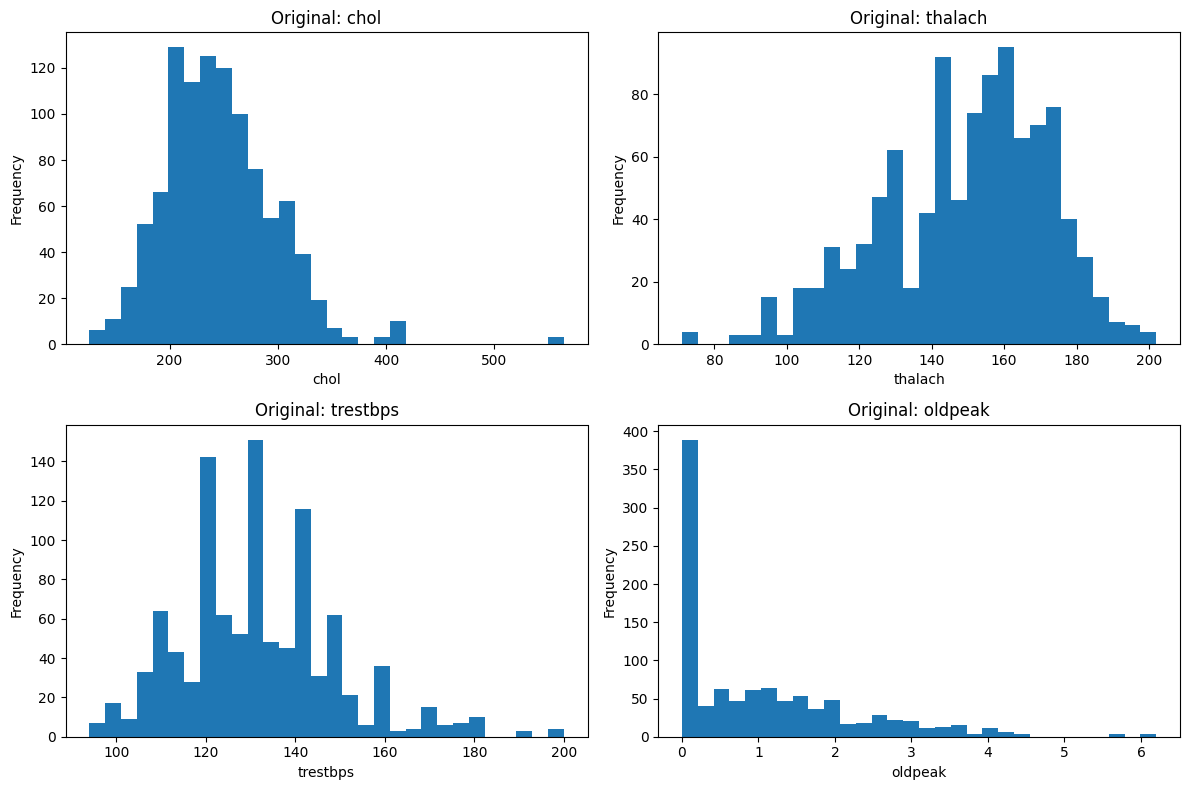

Histograms AFTER replacement


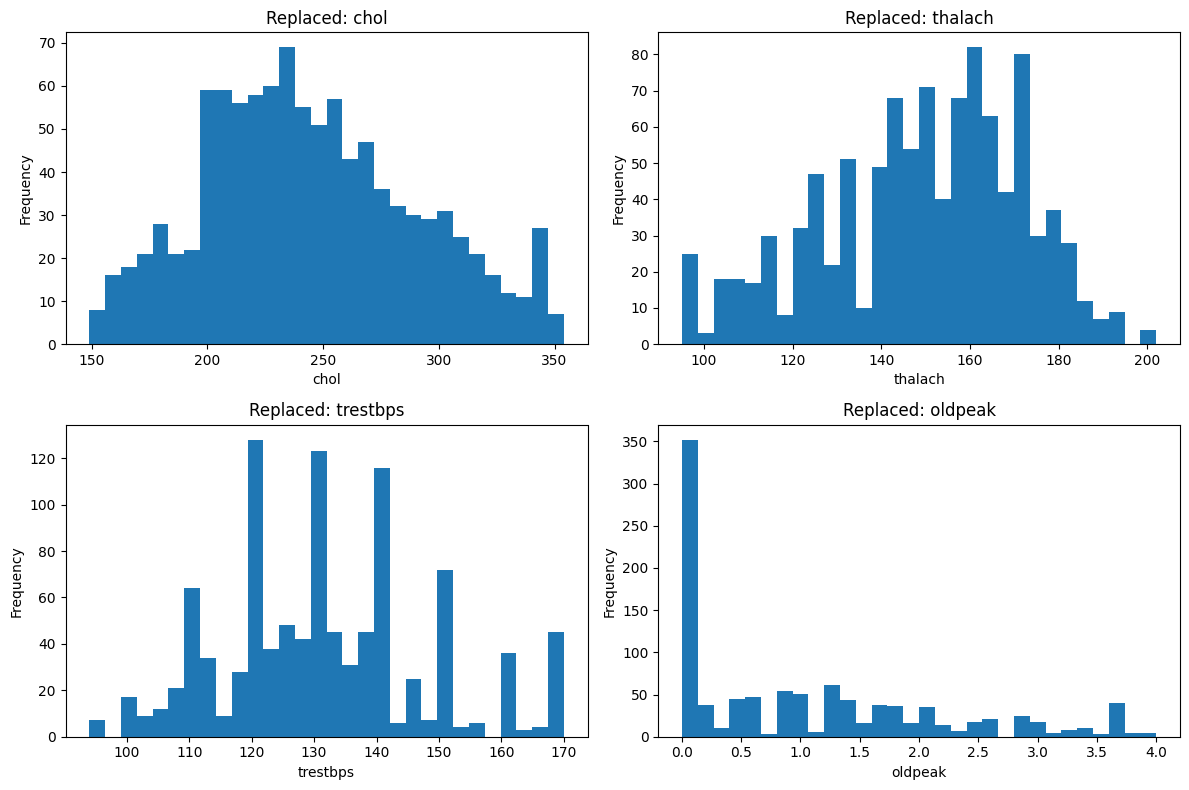

=== Outlier replacement summary ===
KNN outliers:       32 (threshold p97 = 0.5588)
Density outliers:   104 (R=0.6964, p=5)
IQR outliers:       57 (whisker=1.5)
Union (any method): 123
Replaced per column: {'chol': 28, 'thalach': 16, 'trestbps': 30, 'oldpeak': 25}
Summary of replacements per feature:
{'chol': 28, 'thalach': 16, 'trestbps': 30, 'oldpeak': 25}


In [7]:
features = ["chol", "thalach", "trestbps", "oldpeak"]
df = heart_dataset.copy()
df_replaced, info = detect_and_replace_outliers(
    df,
    features=features,
    k=5,
    knn_percentile=97,
    radius_percentile=90,
    iqr_whisker=1.5,
    plot=True,
)

print("Summary of replacements per feature:")
print(info["replaced_per_col"])

# Optional: save the cleaned dataset
# df_replaced.to_csv("heart_outliers_replaced.csv", index=False)


# 3. Feature trasnformation

### Normalization
Feature scaling and distribution check (Min–Max normalization)

Purpose:
This block prepares key continuous cardiovascular features for distance-based analysis and model training by handling missing values, scaling features to a comparable range, and validating the transformation through distribution plots and summary statistics.

- *Targeted feature selection:*
The selected variables (chol, thalach, trestbps, oldpeak) are continuous clinical measurements with different units and numeric ranges, making scaling necessary for fair comparison.

- *NaN handling prior to scaling:*
Rows with missing values are removed (or alternatively median-imputed) to ensure that scaling is computed on valid numeric data and does not propagate NaNs through downstream analyses.

- *Min–Max normalization to [0,1]:*
Scaling maps each feature to a common range, which is especially useful for algorithms sensitive to magnitude differences (e.g., KNN-based outlier detection, neural networks, gradient-based optimization).

- *Optional integration into the original dataset:*
Normalized columns are appended as *_norm to preserve original values while enabling side-by-side use in modelling and interpretation.

###**Results:** This feature transformation had no effect on the feature distribution, non of the features are affected.

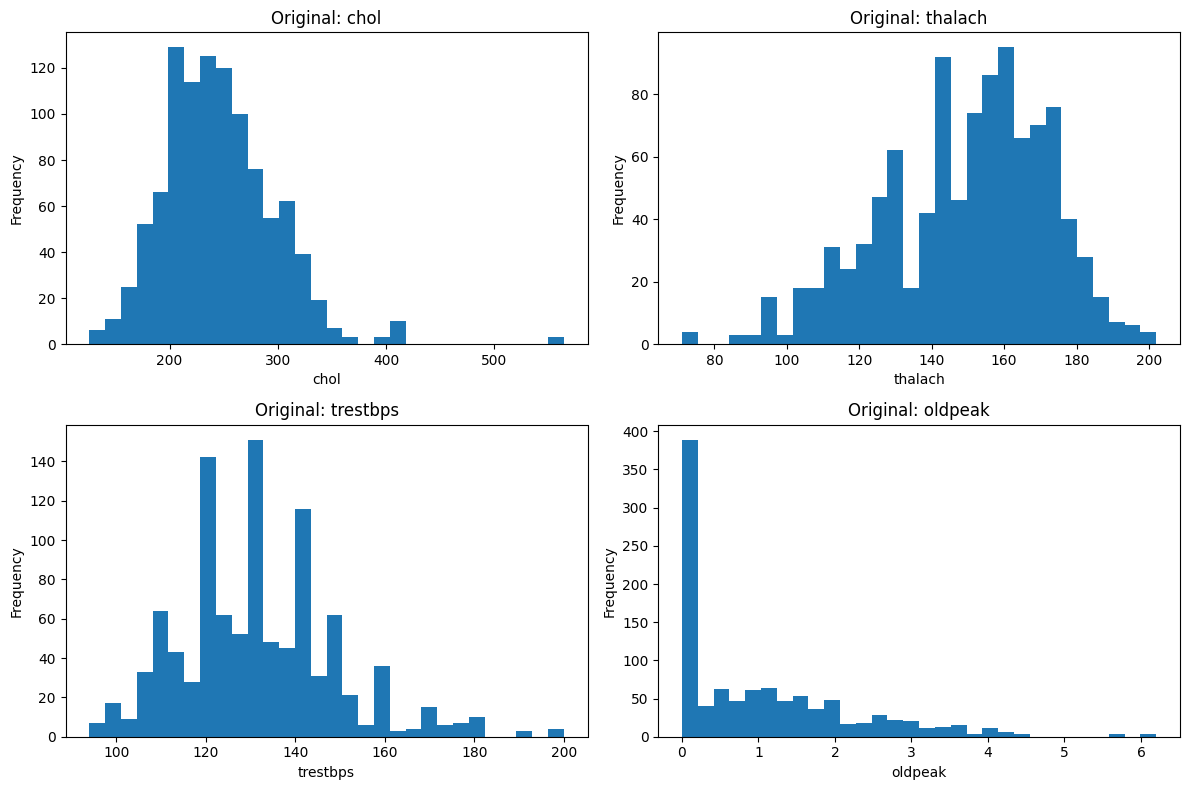

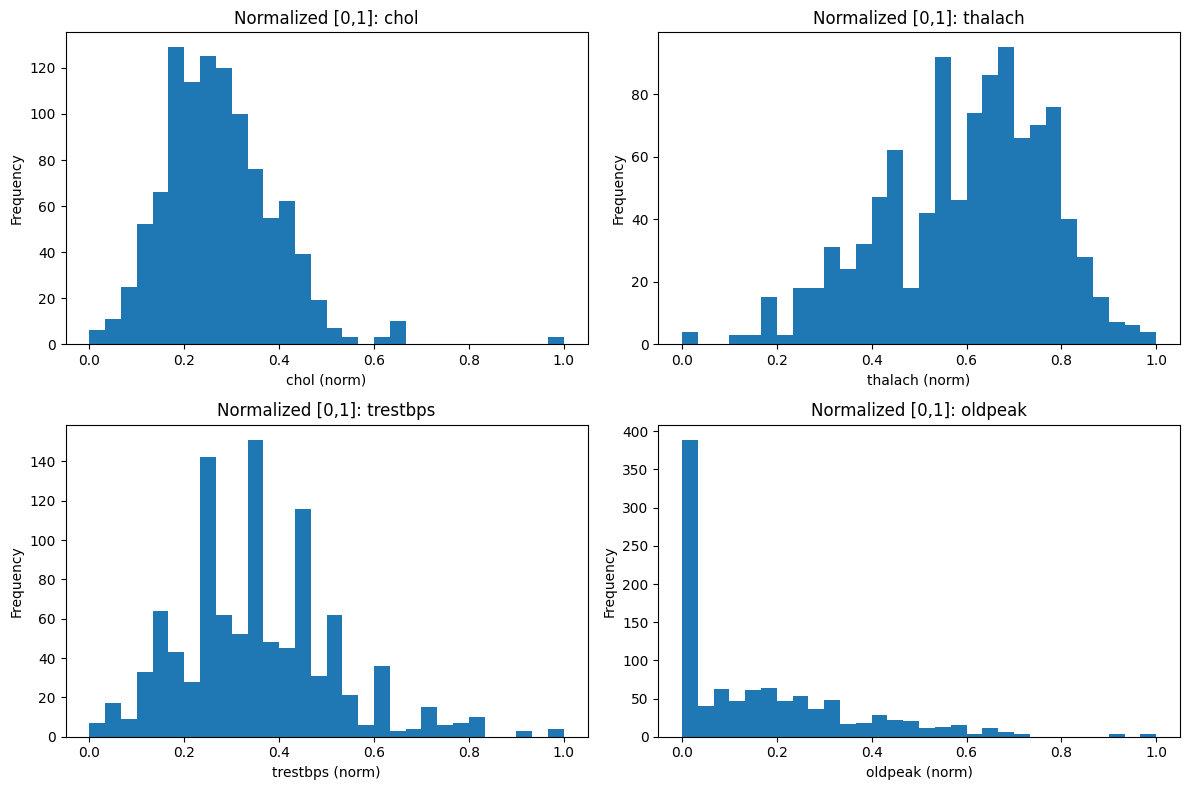

Original summary:


,chol,thalach,trestbps,oldpeak
count,1025.00000,1025.000000,1025.000000,1025.000000
mean,246.00000,149.114146,131.611707,1.071512
std,51.59251,23.005724,17.516718,1.175053
min,126.00000,71.000000,94.000000,0.000000
25%,211.00000,132.000000,120.000000,0.000000
50%,240.00000,152.000000,130.000000,0.800000
75%,275.00000,166.000000,140.000000,1.800000
max,564.00000,202.000000,200.000000,6.200000



Normalized [0,1] summary:


,chol,thalach,trestbps,oldpeak
count,1025.000000,1025.000000,1025.000000,1025.000000
mean,0.273973,0.596291,0.354827,0.172825
std,0.117791,0.175616,0.165252,0.189525
min,0.000000,0.000000,0.000000,0.000000
25%,0.194064,0.465649,0.245283,0.000000
50%,0.260274,0.618321,0.339623,0.129032
75%,0.340183,0.725191,0.433962,0.290323
max,1.000000,1.000000,1.000000,1.000000


In [8]:

# ----- Feature selection -----
features = ["chol", "thalach", "trestbps", "oldpeak"]
X_raw = df[features].copy()

# Simple NaN handling (Option A: drop; Option B: median imputation)
X = X_raw.dropna().copy()
# X = X_raw.fillna(X_raw.median())  # <-- alternative

# ----- Min–Max normalization to [0, 1] -----
scaler = MinMaxScaler()
X_norm = pd.DataFrame(scaler.fit_transform(X), columns=features, index=X.index)

# ===== Alternative scaling options =====
# 1) Z-score standardization:
# zscaler = StandardScaler()
# X_z = pd.DataFrame(zscaler.fit_transform(X), columns=features, index=X.index)

# 2) Robust scaling (median and IQR):
# rscaler = RobustScaler()
# X_robust = pd.DataFrame(rscaler.fit_transform(X), columns=features, index=X.index)

# ----- (Optional) Add normalized columns back to the original df -----
df_norm = df.copy()
for col in features:
    df_norm[f"{col}_norm"] = np.nan
df_norm.loc[X_norm.index, [f"{c}_norm" for c in features]] = X_norm.values

# ----- Histograms: original -----
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for ax, col in zip(axes, features):
    ax.hist(X[col].values, bins=30)
    ax.set_title(f"Original: {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# ----- Histograms: normalized [0, 1] -----
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for ax, col in zip(axes, features):
    ax.hist(X_norm[col].values, bins=30)
    ax.set_title(f"Normalized [0,1]: {col}")
    ax.set_xlabel(f"{col} (norm)")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# ----- Quick summary -----
print("Original summary:")
display(X.describe())
print("\nNormalized [0,1] summary:")
display(X_norm.describe())

# (Optional) Save the dataframe with *_norm columns
# out_path = "/content/heart_normalized.csv"
# df_norm.to_csv(out_path, index=False)
# print(f"\nSaved dataset with normalized columns to: {out_path}")

### Log Transformation

**Purpose:**
This block applies safe logarithmic transformations to selected continuous variables in order to reduce right-skewness, stabilize variance, and improve suitability for statistical analysis and machine-learning models.

- *Numerical stability and safety:*
Custom helper functions (safe_log, safe_log1p) ensure that logarithmic transformations are applied without generating invalid values, handling zeros and negative artefacts robustly.

- *Feature-specific transformation choice:*
Variables such as chol and trestbps are log-transformed when strictly positive, while oldpeak, which may include zero values, is transformed using log1p to preserve zero entries.

- *Explicit traceability:*
Transformed features are stored as new columns (*_log, *_log1p), preserving original measurements for interpretability and comparison.

- *Distributional validation:*
Skewness is reported before and after transformation to quantitatively confirm that the transformation reduces asymmetry without altering data ordering.

| Feature(s)                                                               | Transform  | Did reduce the skewness?       | Main effect                                       | Notes                                    |
| ------------------------------------------------------------------------ | ---------- | ------------- | ------------------------------------------------- | ---------------------------------------- |
| **chol**                                                                 | `log(x)`   | **Yes**       | Reduces right-skew & outlier leverage             | Improves linearity for GLM/Logistic      |
| **trestbps**                                                             | `log(x)`   | **Yes**       | More symmetric distribution; stabler coefficients | Similar benefits to *chol*               |
| **oldpeak**                                                              | `log1p(x)` | **Partially** | Compresses tail; still mass at 0                  | Consider splines if nonlinearity remains |
| **thalach**                                                              | —          | **No**        | Often left-skew; log doesn’t help                 | Try splines or no transform              |
| **age**                                                                  | —          | **No**        | Little gain from log                              | Keep as is or standardize                |
| **Categoricals** (sex, cp, fbs, restecg, exang, slope, ca, thal, target) | —          | **No**        | Not suitable for log                              | Use as categorical/ordinal features      |


In [9]:
# --- Safe helpers ---
def safe_log(series: pd.Series) -> pd.Series:
    """
    Apply natural logarithm to strictly positive data.
    If non-positive values are present, clip negatives to 0 and use log1p.
    """
    s = series.copy()
    if (s <= 0).any():
        s = s.clip(lower=0)
        return np.log1p(s)
    return np.log(s)

def safe_log1p(series: pd.Series) -> pd.Series:
    """Always apply log1p after clipping negatives to 0."""
    return np.log1p(series.clip(lower=0))


# --- Apply canonical transformations for the Heart dataset ---
cols_to_make = []

if "chol" in df.columns:
    df["chol_log"] = safe_log(df["chol"])
    cols_to_make.append(("chol", "chol_log"))

if "trestbps" in df.columns:
    df["trestbps_log"] = safe_log(df["trestbps"])
    cols_to_make.append(("trestbps", "trestbps_log"))

if "oldpeak" in df.columns:
    # oldpeak may contain zeros, so log1p is preferred
    df["oldpeak_log1p"] = safe_log1p(df["oldpeak"])
    cols_to_make.append(("oldpeak", "oldpeak_log1p"))

print("Created transformed columns:", cols_to_make)


# --- Skewness comparison before / after transformation ---
def skew_report(col_raw, col_tx):
    if col_raw in df.columns and col_tx in df.columns:
        print(
            f"{col_raw:>15}  "
            f"skew(before)={df[col_raw].dropna().skew(): .3f}  "
            f"skew(after)={df[col_tx].dropna().skew(): .3f}"
        )

for raw, tx in cols_to_make:
    skew_report(raw, tx)

df.head()


Created transformed columns: [('chol', 'chol_log'), ('trestbps', 'trestbps_log'), ('oldpeak', 'oldpeak_log1p')]
           chol  skew(before)= 1.074  skew(after)= 0.079
       trestbps  skew(before)= 0.740  skew(after)= 0.302
        oldpeak  skew(before)= 1.211  skew(after)= 0.358


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,chol_log,trestbps_log,oldpeak_log1p
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0,5.356586,4.828314,0.693147
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0,5.313206,4.941642,1.410987
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0,5.159055,4.976734,1.280934
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,5.313206,4.997212,0.000000
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,5.683580,4.927254,1.064711


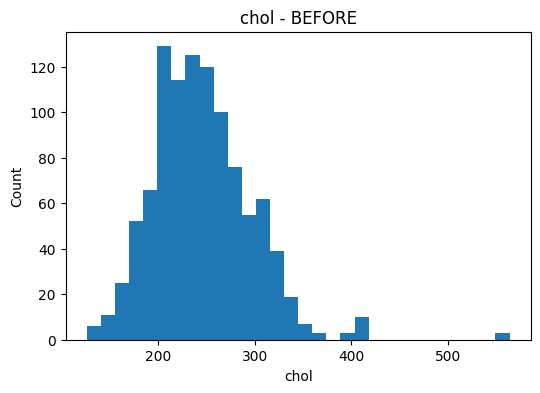

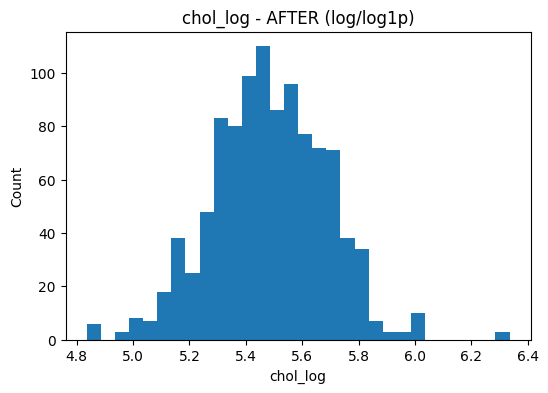

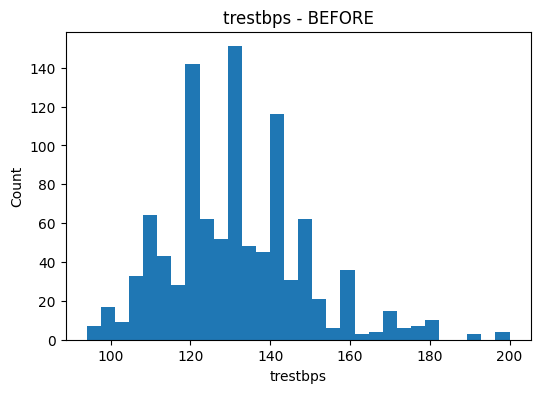

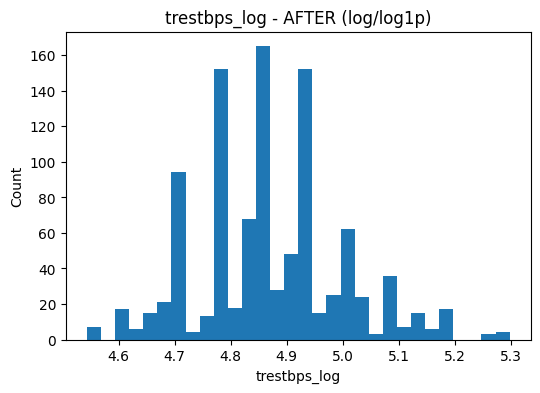

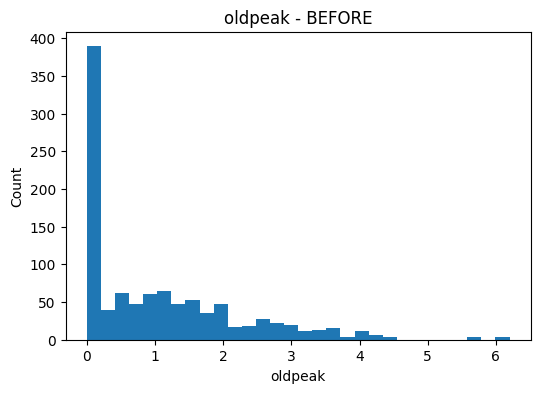

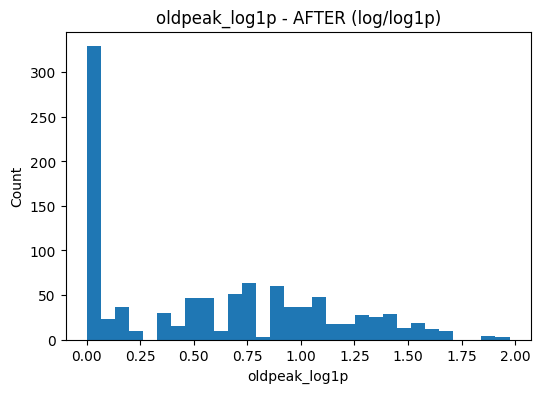

In [10]:
pairs = [("chol", "chol_log"), ("trestbps", "trestbps_log"), ("oldpeak", "oldpeak_log1p")]

for raw, tx in pairs:
    if raw in df.columns and tx in df.columns:
        # BEFORE
        plt.figure(figsize=(6,4))
        plt.hist(df[raw].dropna(), bins=30)
        plt.title(f"{raw} - BEFORE")
        plt.xlabel(raw); plt.ylabel("Count")
        plt.show()

        # AFTER
        plt.figure(figsize=(6,4))
        plt.hist(df[tx].dropna(), bins=30)
        plt.title(f"{tx} - AFTER (log/log1p)")
        plt.xlabel(tx); plt.ylabel("Count")
        plt.show()


### Numerization and discretization (optional)

**Purpose:**
This cell converts categorical variables from the Heart Disease dataset into machine-learning–ready numerical features, while also creating human-readable label columns to improve interpretability during EDA and reporting.

- *Human-readable mappings for inspection:*
Mapping dictionaries (e.g., sex, cp, thal, target) create *_label columns so categorical codes can be interpreted directly when reviewing tables, plots, and sample records.

- *Type-aware feature definition:*
Features are split into numeric, ordinal, and nominal groups to ensure each variable is encoded according to its measurement scale and meaning.

- *Explicit ordinal ordering:*
OrdinalEncoder is applied with predefined category orders to preserve meaningful rank structure (e.g., ordered clinical categories), avoiding arbitrary numeric assumptions.

- *Nominal one-hot encoding with safe handling:*
OneHotEncoder(handle_unknown="ignore") converts nominal binary features into independent indicator variables and prevents failures when unseen categories appear (e.g., in validation/test splits).

- *Reproducible preprocessing via ColumnTransformer:*
Encoding is performed in a single fitted transformer, ensuring consistent transformations and reducing leakage or mismatched preprocessing between training and evaluation.

- *Traceable output dataset:*
The encoded feature matrix is rebuilt as a DataFrame with explicit column names (including expanded one-hot names), making downstream modelling, feature importance, and documentation straightforward.

In [11]:
# ============================================================
# Discretization & Encoding of Nominal and Ordinal Variables
# for the Heart Disease Dataset (Google Colab - Single Cell)
# ============================================================

# 0) Install required libraries
!pip -q install pandas numpy scikit-learn

import io
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from google.colab import files

# 2) Mapping dictionaries for readability
map_sex     = {0: "Female", 1: "Male"}
map_fbs     = {0: "False",  1: "True"}
map_exang   = {0: "No",     1: "Yes"}
map_target  = {0: "No heart disease", 1: "Heart disease"}

map_cp = {
    0: "Typical angina",
    1: "Atypical angina",
    2: "Non-anginal pain",
    3: "Asymptomatic"
}
map_restecg = {
    0: "Normal",
    1: "ST-T wave abnormality",
    2: "Left ventricular hypertrophy"
}
map_slope = {
    0: "Upsloping",
    1: "Flat",
    2: "Downsloping"
}
map_thal = {
    0: "Unknown",
    1: "Fixed defect",
    2: "Normal",
    3: "Reversible defect"
}

# 3) Create readable label columns
heart_lbl = heart_dataset.copy()
if "sex" in heart_lbl:     heart_lbl["sex_label"] = heart_lbl["sex"].map(map_sex)
if "fbs" in heart_lbl:     heart_lbl["fbs_label"] = heart_lbl["fbs"].map(map_fbs)
if "exang" in heart_lbl:   heart_lbl["exang_label"] = heart_lbl["exang"].map(map_exang)
if "target" in heart_lbl:  heart_lbl["target_label"] = heart_lbl["target"].map(map_target)
if "cp" in heart_lbl:      heart_lbl["cp_label"] = heart_lbl["cp"].map(map_cp)
if "restecg" in heart_lbl: heart_lbl["restecg_label"] = heart_lbl["restecg"].map(map_restecg)
if "slope" in heart_lbl:   heart_lbl["slope_label"] = heart_lbl["slope"].map(map_slope)
if "thal" in heart_lbl:    heart_lbl["thal_label"] = heart_lbl["thal"].map(map_thal)

print("✅ Human-readable *_label columns created.")
display(heart_lbl.head())

# 4) Define columns by type
numeric_cols = [c for c in ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"] if c in df.columns]
ordinal_cols = [c for c in ["cp", "restecg", "slope", "thal"] if c in df.columns]
nominal_cols = [c for c in ["sex", "fbs", "exang"] if c in df.columns]
label_col    = "target"
has_target   = label_col in df.columns

# Explicit order for ordinal features
ord_cats_map = {
    "cp":      [0, 1, 2, 3],
    "restecg": [0, 1, 2],
    "slope":   [0, 1, 2],
    "thal":    [0, 1, 2, 3],
}
ordinal_categories = [ord_cats_map[c] for c in ordinal_cols]

# 5) Build feature and target sets
X_cols = ordinal_cols + nominal_cols + numeric_cols
X = df[X_cols].copy()
y = df[label_col].copy() if has_target else None

# 6) ColumnTransformer for encoding
ct = ColumnTransformer(
    transformers=[
        ("ord", OrdinalEncoder(categories=ordinal_categories, dtype=int), ordinal_cols),
        ("nom", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), nominal_cols),
        ("num", "passthrough", numeric_cols)
    ],
    remainder="drop"
)

X_enc = ct.fit_transform(X)

# 7) Build encoded dataframe
ord_names = [f"{col}_ord" for col in ordinal_cols]

nom_encoder = [tr for tr in ct.transformers_ if tr[0] == "nom"][0][1]
nom_feature_names = []
for col, cats in zip(nominal_cols, nom_encoder.categories_):
    nom_feature_names.extend([f"{col}__{str(cat)}" for cat in cats])

final_feature_names = ord_names + nom_feature_names + numeric_cols
X_enc_df = pd.DataFrame(X_enc, columns=final_feature_names, index=df.index)

if has_target:
    X_enc_df[label_col] = y

print("✅ Encoding completed.")
print("Final columns:", X_enc_df.columns.tolist())
display(X_enc_df.head())

# 8) Save results
#heart_lbl.to_csv("heart_with_labels.csv", index=False)
ord_only = df[ordinal_cols].copy()
ord_only.columns = [f"{c}_ord" for c in ord_only.columns]
#ord_only.to_csv("heart_ordinals_only.csv", index=False)
#_enc_df.to_csv("heart_final_encoded.csv", index=False)

#print("💾 Files saved:")
#print(" - heart_with_labels.csv")
#print(" - heart_ordinals_only.csv")
#print(" - heart_final_encoded.csv")

# 9) Auto-download (optional)
#files.download("heart_with_labels.csv")
#files.download("heart_ordinals_only.csv")
#files.download("heart_final_encoded.csv")

# 10) Quick verification
print("\nDtypes of encoded dataset:")
print(X_enc_df.dtypes)
print("\nRandom sample:")
display(X_enc_df.sample(min(5, len(X_enc_df)), random_state=42))


✅ Human-readable *_label columns created.


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,thal,target,sex_label,fbs_label,exang_label,target_label,cp_label,restecg_label,slope_label,thal_label
0,52,1,0,125,212,0,1,168,0,1.0,...,3,0,Male,False,No,No heart disease,Typical angina,ST-T wave abnormality,Downsloping,Reversible defect
1,53,1,0,140,203,1,0,155,1,3.1,...,3,0,Male,True,Yes,No heart disease,Typical angina,Normal,Upsloping,Reversible defect
2,70,1,0,145,174,0,1,125,1,2.6,...,3,0,Male,False,Yes,No heart disease,Typical angina,ST-T wave abnormality,Upsloping,Reversible defect
3,61,1,0,148,203,0,1,161,0,0.0,...,3,0,Male,False,No,No heart disease,Typical angina,ST-T wave abnormality,Downsloping,Reversible defect
4,62,0,0,138,294,1,1,106,0,1.9,...,2,0,Female,True,No,No heart disease,Typical angina,ST-T wave abnormality,Flat,Normal


✅ Encoding completed.
Final columns: ['cp_ord', 'restecg_ord', 'slope_ord', 'thal_ord', 'sex__0', 'sex__1', 'fbs__0', 'fbs__1', 'exang__0', 'exang__1', 'age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'target']


,cp_ord,restecg_ord,slope_ord,thal_ord,sex__0,sex__1,fbs__0,fbs__1,exang__0,exang__1,age,trestbps,chol,thalach,oldpeak,ca,target
0,0.0,1.0,2.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,52.0,125.0,212.0,168.0,1.0,2.0,0
1,0.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,53.0,140.0,203.0,155.0,3.1,0.0,0
2,0.0,1.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,70.0,145.0,174.0,125.0,2.6,0.0,0
3,0.0,1.0,2.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,61.0,148.0,203.0,161.0,0.0,1.0,0
4,0.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,62.0,138.0,294.0,106.0,1.9,3.0,0



Dtypes of encoded dataset:
cp_ord         float64
restecg_ord    float64
slope_ord      float64
thal_ord       float64
sex__0         float64
sex__1         float64
fbs__0         float64
fbs__1         float64
exang__0       float64
exang__1       float64
age            float64
trestbps       float64
chol           float64
thalach        float64
oldpeak        float64
ca             float64
target           int64
dtype: object

Random sample:


,cp_ord,restecg_ord,slope_ord,thal_ord,sex__0,sex__1,fbs__0,fbs__1,exang__0,exang__1,age,trestbps,chol,thalach,oldpeak,ca,target
527,0.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,62.0,124.0,209.0,163.0,0.0,0.0,1
359,2.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,53.0,128.0,216.0,115.0,0.0,0.0,1
447,0.0,0.0,1.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,55.0,160.0,289.0,145.0,0.8,1.0,0
31,1.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,50.0,120.0,244.0,162.0,1.1,0.0,1
621,0.0,0.0,2.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,48.0,130.0,256.0,150.0,0.0,2.0,0


# Credits
##Raquel Hernanz Hernández